# Presentation analyses

In [126]:
import qiime2
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from qiime2.plugins import feature_table, fragment_insertion, feature_classifier, metadata, empress, songbird

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
import seaborn as sns
%matplotlib inline

In [127]:
# Data and results directories
data_dir = '../data/full/2020_05_11'
results_dir = '../results/full/2020_05_15'
tax_dir = '{}/taxonomy'.format(results_dir)
table_dir = '{}/feature_tables'.format(results_dir)
tree_dir = '{}/fragment_insertion'.format(results_dir)
diversity_dir = '{}/diversity'.format(results_dir)
diff_dir = '{}/differential_abundance'.format(results_dir)
tree_dir = '{}/fragment_insertion'.format(results_dir)

# Fine-tun feature table

### Load feature table and metadata

In [128]:
filtered_table = qiime2.Artifact.load('{}/insertion-table.qza'.format(table_dir))

In [133]:
meta_data = qiime2.Metadata.load('{}/filtered-metadata.tsv'.format(data_dir))

### Filter out "Never" samples

In [145]:
criterion = "[exercise_frequency] IN ('Rarely (a few times/month)', 'Occasionally (1-2 times/week)', 'Regularly (3-5 times/week)', 'Daily')"
min_per_feature = 3

In [137]:
# Filter FeatureTable[Frequency] with feature-table filter-samples method
sample_filter = feature_table.methods.filter_samples(table=filtered_table, 
                                                     metadata=meta_data,
                                                     where=criterion)

In [146]:
# Filter FeatureTable[Frequency] with feature-table filter-features method
feature_filter = feature_table.methods.filter_features(table=sample_filter.filtered_table,
                                                       min_frequency=min_per_feature)

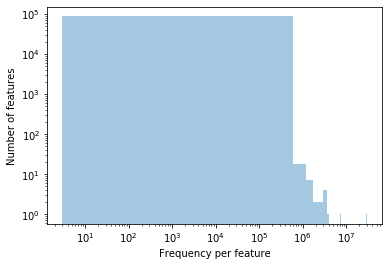

In [147]:
# Visualize the filtered table
feature_filter_vis = feature_table.visualizers.summarize(table=feature_filter.filtered_table,
                                                         sample_metadata=meta_data)

In [149]:
#feature_filter_vis.visualization

#### Get counts

In [ ]:
filtered_df = feature_filter.filtered_table.view(pd.DataFrame)

In [151]:
counts = filtered_df.sum(axis=0)

In [152]:
print("Number of zero count features %d" % (counts == 0).sum())
print("Number of singleton features %d" % (counts == 1).sum())
print("Number of doubleton features %d" % (counts == 2).sum())
print("Number of features with a count of >2 %d" % (counts > 2).sum())

Number of zero count features 0
Number of singleton features 0
Number of doubleton features 0
Number of features with a count of >2 85716


In [154]:
sample_ids = filtered_df.index
sample_ids[0:5]

Index(['10317.000020104.56754', '10317.000028711.57900',
       '10317.000013255.60418', '10317.000068081.60111',
       '10317.000022101.58699'],
      dtype='object')

In [235]:
meta_data_df = meta_data.to_dataframe().loc[sample_ids]

In [236]:
meta_data_df["exercise_frequency"].value_counts()

Regularly (3-5 times/week)       2886
Occasionally (1-2 times/week)    1705
Daily                            1458
Rarely (a few times/month)        716
Name: exercise_frequency, dtype: int64

[Text(0, 0, 'Rarely (n=716)'),
 Text(0, 0, 'Occasionally (n=1705)'),
 Text(0, 0, 'Regularly (n=2886)'),
 Text(0, 0, 'Daily (n=1458)')]

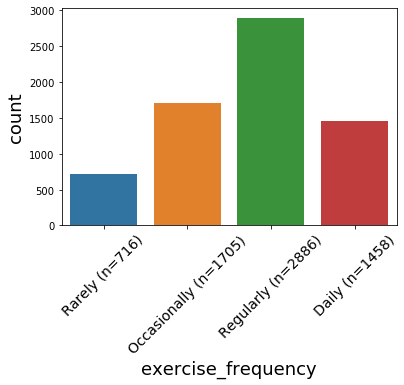

In [237]:
ax = sns.countplot(x='exercise_frequency', data=meta_data_df, order=['Rarely (a few times/month)', 'Occasionally (1-2 times/week)', 
                                                                       'Regularly (3-5 times/week)', 'Daily'])
ax.set_xticklabels(["Rarely (n=716)", "Occasionally (n=1705)", "Regularly (n=2886)", "Daily (n=1458)"], rotation=45)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

In [238]:
meta_data_df["bmi_corrected"].replace("Not provided", np.nan, inplace=True)
meta_data_df["age_corrected"].replace("Not provided", np.nan, inplace=True)

In [239]:
mean_bmi = int((meta_data_df["bmi_corrected"].replace("", np.nan)).astype('float64').mean())
mean_age = int((meta_data_df["age_corrected"].replace("", np.nan)).astype('float64').mean())

In [240]:
meta_data_df["bmi_corrected"].replace(np.nan, mean_bmi, inplace=True)
meta_data_df["age_corrected"].replace(np.nan, mean_age, inplace=True)

In [248]:
meta_data_df.index.rename('#SampleID', inplace=True)
meta_data_df = meta_data_df.astype({'age_corrected': 'float64', 'bmi_corrected':'float64'})
meta_data_df = meta_data_df.astype({'age_corrected': 'int64', 'bmi_corrected':'int64'})

In [250]:
m_data = qiime2.Metadata(meta_data_df)

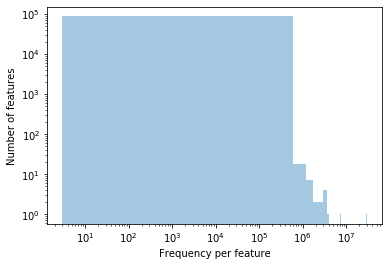

In [251]:
# Visualize the filtered table
feature_filter_vis = feature_table.visualizers.summarize(table=feature_filter.filtered_table,
                                                         sample_metadata=m_data)

In [253]:
#feature_filter_vis.visualization

In [258]:
m_data.save('{}/cleaned-metadata.tsv'.format(data_dir))
feature_filter.filtered_table.save('{}/never-removed-table'.format(table_dir))
feature_filter_vis.visualization.save('{}/never-removed-table.qzv'.format(table_dir))

'../results/full/2020_05_15/feature_tables/never-removed-table.qzv'

# Taxonomic classification details

In [76]:
bespoke_taxonomy = qiime2.Artifact.load('{}/bespoke-taxonomy.qza'.format(tax_dir))

In [77]:
taxonomy_df = bespoke_taxonomy.view(pd.DataFrame)

In [78]:
taxonomy_df["Confidence"] = taxonomy_df["Confidence"].astype(float)

In [79]:
print("Percentage of features classified with > 90%% confidence: %.2f%%" % (100*(taxonomy_df["Confidence"] > 0.90).sum()/len(taxonomy_df)))

Percentage of features classified with > 90% confidence: 80.57%


Text(0.5, 0, 'Confidence')

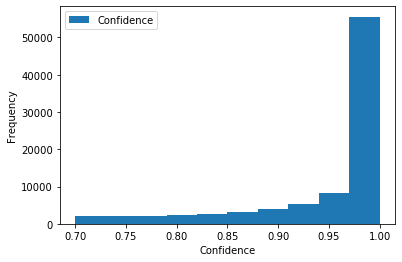

In [80]:
ax = taxonomy_df.plot.hist("Confidence")
ax.set_xlabel("Confidence")

In [81]:
taxon_counts = {"k":0, "p":0, "c":0, "o":0, "f":0, "g":0, "s":0}
for classification in taxonomy_df["Taxon"].values:
    taxons = classification.split('; ')
    for i, cl in enumerate(taxons):
        if i > 0 and len(cl) < 4:
            taxon_counts[taxons[i-1][0]] += 1
            break
        if i == len(taxons)-1:
            taxon_counts[taxons[len(taxons)-1][0]] += 1

In [82]:
taxon_counts = pd.Series(taxon_counts)

In [83]:
taxon_frac = taxon_counts/taxon_counts.sum()

In [126]:
viridis = cm.get_cmap('viridis', 12)
set_three = cm.get_cmap('Set3', 20)

[Text(0, 0, 'Kingdom'),
 Text(0, 0, 'Phylum'),
 Text(0, 0, 'Class'),
 Text(0, 0, 'Order'),
 Text(0, 0, 'Family'),
 Text(0, 0, 'Genus'),
 Text(0, 0, 'Species')]

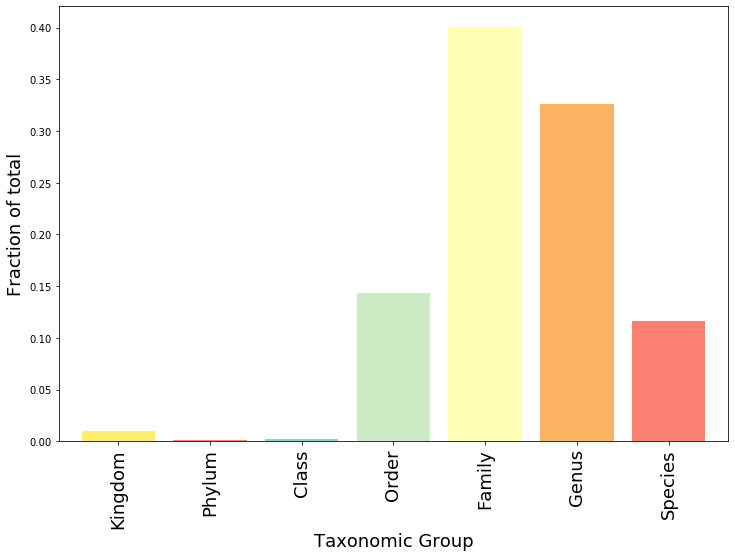

In [130]:
ax = plt.figure(figsize=(12,8))
ax = taxon_frac.plot.bar(color=[set_three(np.random.random()) for i in range(len(taxon_frac))], width=0.8)
ax.set_xlabel("Taxonomic Group", fontsize=18)
ax.set_ylabel("Fraction of total", fontsize=18)
ax.set_xticklabels(["Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species"], fontsize=18)

# Alpha rarefaction details

In [144]:
plot_dir = '{}/plotting'.format(results_dir)

In [145]:
shannon_df = pd.read_csv('{}/shannon.csv'.format(plot_dir))

In [146]:
shannon_df.head()

,sample-id,depth-1_iter-1,depth-1_iter-2,depth-1_iter-3,depth-1_iter-4,depth-1_iter-5,depth-1_iter-6,depth-1_iter-7,depth-1_iter-8,depth-1_iter-9,...,depth-10000_iter-10,age_corrected,sex,body_site,sample_type,bmi_corrected,exercise_frequency,country,race,diet_type
0,10317.000020104.56754,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,1.515963,38.0,male,UBERON:feces,Stool,Not provided,Regularly (3-5 times/week),USA,Caucasian,Omnivore
1,10317.000028711.57900,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,4.588041,49.0,female,UBERON:feces,Stool,Not provided,Occasionally (1-2 times/week),USA,Caucasian,Omnivore
2,10317.000013255.60418,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,5.048281,61.0,female,UBERON:feces,Stool,Not provided,Daily,USA,Caucasian,Omnivore
3,10317.000068081.60111,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,5.714992,50.0,female,UBERON:feces,Stool,25.85,Occasionally (1-2 times/week),USA,Caucasian,Vegetarian
4,10317.000022101.58699,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,NaN,34.0,male,UBERON:feces,Stool,Not provided,Occasionally (1-2 times/week),Australia,Caucasian,Omnivore


[Text(0, 0, '0'),
 Text(0, 0, '1000'),
 Text(0, 0, '2000'),
 Text(0, 0, '3000'),
 Text(0, 0, '4000'),
 Text(0, 0, '5000')]

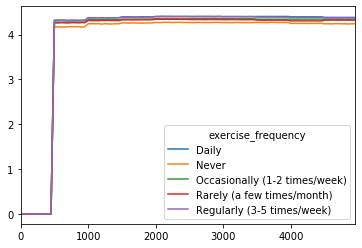

In [148]:
ax = shannon_df.groupby("exercise_frequency").mean().T.plot.line()
ax.set_xticklabels(np.arange(0, 10000, 1000))

# Diversity

In [152]:
shannon_vec = qiime2.Artifact.load('{}/shannon-vector.qza'.format(diversity_dir))

In [163]:
shannon_df = pd.DataFrame(shannon_vec.view(pd.Series))

In [173]:
shannon_meta_df = shannon_df.join(meta_data_df, how='inner')

In [186]:
shannon_meta_df["exercise_frequency"].value_counts()

Regularly (3-5 times/week)       2726
Occasionally (1-2 times/week)    1615
Daily                            1378
Rarely (a few times/month)        681
Never                             160
Name: exercise_frequency, dtype: int64

In [185]:
import seaborn as sns

In [236]:
shannon_meta_df.groupby("exercise_frequency").median()

,shannon
exercise_frequency,
Daily,4.656783
Never,4.614764
Occasionally (1-2 times/week),4.623732
Rarely (a few times/month),4.657309
Regularly (3-5 times/week),4.700750


[Text(0, 0, 'Never (n=160)'),
 Text(0, 0, 'Rarely (n=681)'),
 Text(0, 0, 'Occasionally (n=1615)'),
 Text(0, 0, 'Regularly (n=2726)'),
 Text(0, 0, 'Daily (n=1378)')]

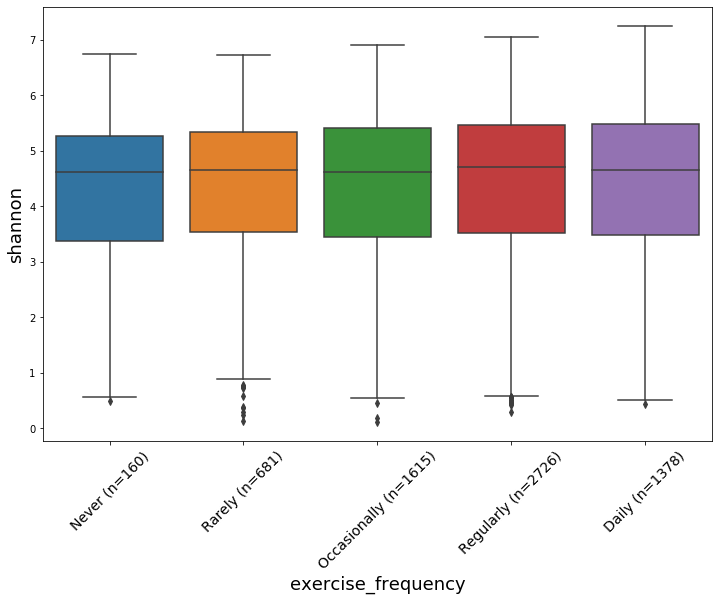

In [235]:
ax = plt.figure(figsize=(12,8))
ax = sns.boxplot(x='exercise_frequency', y='shannon', data=shannon_meta_df, order=["Never", "Rarely (a few times/month)", "Occasionally (1-2 times/week)",
                                                                                 "Regularly (3-5 times/week)", "Daily"])
ax.set_xticklabels(["Never (n=160)", "Rarely (n=681)", "Occasionally (n=1615)", "Regularly (n=2726)", "Daily (n=1378)"], rotation=45)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

In [219]:
shannon_kruskal = stats.kruskal(*[group["shannon"].values for name, group in shannon_meta_df.groupby("exercise_frequency")])

In [224]:
shannon_kruskal.statistic

5.193694174278789

In [196]:
faiths_vec = qiime2.Artifact.load('{}/faith-pd-vector.qza'.format(diversity_dir))

In [197]:
faiths_df = pd.DataFrame(faiths_vec.view(pd.Series))

In [200]:
faiths_meta_df = faiths_df.join(meta_data_df, how='inner')

In [206]:
faiths_meta_df.head()

,faith_pd,age_corrected,sex,body_site,sample_type,bmi_corrected,exercise_frequency,country,race,diet_type
10317.000020104.56754,8.465714,38.0,male,UBERON:feces,Stool,Not provided,Regularly (3-5 times/week),USA,Caucasian,Omnivore
10317.000028711.57900,20.746500,49.0,female,UBERON:feces,Stool,Not provided,Occasionally (1-2 times/week),USA,Caucasian,Omnivore
10317.000013255.60418,22.817671,61.0,female,UBERON:feces,Stool,Not provided,Daily,USA,Caucasian,Omnivore
10317.000068081.60111,24.646709,50.0,female,UBERON:feces,Stool,25.85,Occasionally (1-2 times/week),USA,Caucasian,Vegetarian
10317.000022101.58699,10.913315,34.0,male,UBERON:feces,Stool,Not provided,Occasionally (1-2 times/week),Australia,Caucasian,Omnivore


In [201]:
faiths_meta_df["exercise_frequency"].value_counts()

Regularly (3-5 times/week)       2726
Occasionally (1-2 times/week)    1615
Daily                            1378
Rarely (a few times/month)        681
Never                             160
Name: exercise_frequency, dtype: int64

[Text(0, 0, 'Never (n=160)'),
 Text(0, 0, 'Rarely (n=681)'),
 Text(0, 0, 'Occasionally (n=1615)'),
 Text(0, 0, 'Regularly (n=2726)'),
 Text(0, 0, 'Daily (n=1378)')]

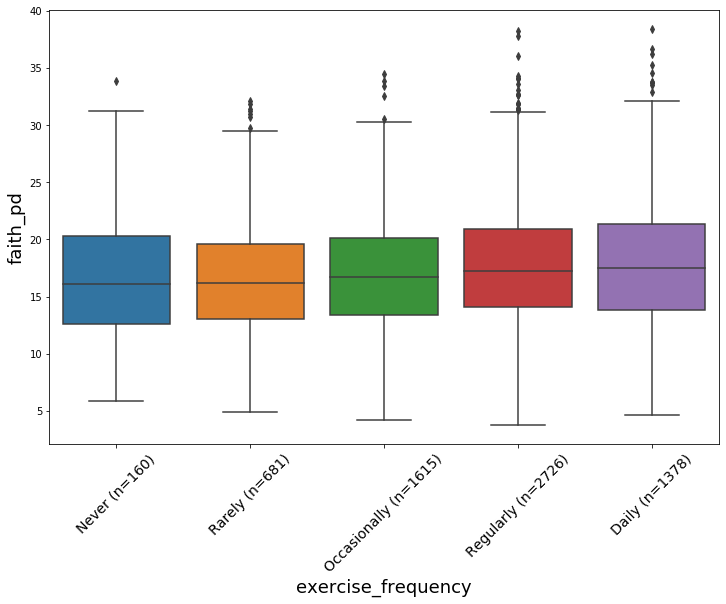

In [237]:
ax = plt.figure(figsize=(12,8))
ax = sns.boxplot(x='exercise_frequency', y='faith_pd', data=faith_meta_df, order=["Never", "Rarely (a few times/month)", "Occasionally (1-2 times/week)",
                                                                                 "Regularly (3-5 times/week)", "Daily"])
ax.set_xticklabels(["Never (n=160)", "Rarely (n=681)", "Occasionally (n=1615)", "Regularly (n=2726)", "Daily (n=1378)"], rotation=45)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

In [217]:
from scipy import stats
faiths_kruskal = stats.kruskal(*[group["faith_pd"].values for name, group in faith_meta_df.groupby("exercise_frequency")])

In [ ]:
faiths_kruskal

# Beta diversity

In [250]:
from skbio import DistanceMatrix

uw_dm = qiime2.Artifact.load('{}/uw-unifrac-distance-matrix.qza'.format(diversity_dir)).view(DistanceMatrix)
uw_df = uw_dm.to_data_frame()

In [251]:
uw_df.head()

,10317.000020104.56754,10317.000028711.57900,10317.000013255.60418,10317.000068081.60111,10317.000022101.58699,10317.000052018.58828,10317.000011143.57854,10317.000011036.56878,10317.000105301.66110,10317.000002202.60204,...,10317.000108647.79396,10317.000013614.59891,10317.000068527.59891,10317.000020655.67836,10317.000107550.74745,10317.000047574.60472,10317.000026504.56754,10317.000035441.57180,10317.000009392.60204,10317.000063585.58828
10317.000020104.56754,0.000000,0.724843,0.747448,0.758872,0.582593,0.630135,0.653458,0.638541,0.729428,0.620893,...,0.730217,0.558377,0.576355,0.692950,0.714567,0.575546,0.678564,0.687699,0.637420,0.724836
10317.000028711.57900,0.724843,0.000000,0.591309,0.634243,0.698776,0.681914,0.623563,0.613800,0.563026,0.627500,...,0.599503,0.637126,0.618874,0.602819,0.580733,0.655002,0.620935,0.576550,0.760828,0.637254
10317.000013255.60418,0.747448,0.591309,0.000000,0.612443,0.700068,0.688240,0.587071,0.627214,0.575878,0.648272,...,0.631921,0.659665,0.589456,0.544385,0.554187,0.656549,0.600384,0.540497,0.786709,0.641814
10317.000068081.60111,0.758872,0.634243,0.612443,0.000000,0.715458,0.710801,0.615191,0.631147,0.559342,0.670715,...,0.551506,0.684322,0.609642,0.581300,0.559490,0.671520,0.557909,0.550991,0.789359,0.608086
10317.000022101.58699,0.582593,0.698776,0.700068,0.715458,0.000000,0.549705,0.614751,0.592336,0.691009,0.595650,...,0.721467,0.580172,0.567738,0.617233,0.621976,0.541556,0.641770,0.688962,0.664610,0.705721


In [255]:
cat = meta_data_df["exercise_frequency"].loc[uw_df.index]

In [256]:
from skbio.stats.distance import permanova
permanova(uw_dm, cat)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                    6560
number of groups                  5
test statistic              3.79834
p-value                       0.001
number of permutations          999
Name: PERMANOVA results, dtype: object

In [258]:
differentials = qiime2.Artifact.load('{}/differentials.qza'.format(diff_dir))
differentials_vis = metadata.visualizers.tabulate(differentials.view(qiime2.Metadata))
differentials_vis.visualization.save('{}/differentials.qzv'.format(diff_dir))

'../results/full/2020_05_15/differential_abundance/differentials.qzv'

In [269]:
songbird_df = differentials.view(pd.DataFrame).join(taxonomy_df, how='inner')

In [270]:
top10 = songbird_df["exercise_frequency[T.Never]"].sort_values()[0:10].index

In [273]:
songbird_df.loc[top10]["Taxon"].values

array(['k__Bacteria; p__Proteobacteria; c__Betaproteobacteria; o__Burkholderiales; f__Comamonadaceae; g__Comamonas; s__',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Providencia; s__',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Morganella; s__morganii',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Xanthomonadales; f__Xanthomonadaceae; g__Stenotrophomonas; s__acidaminiphila',
       'k__Bacteria; p__Bacteroidetes; c__Bacteroidia; o__Bacteroidales; f__S24-7; g__; s__',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Xanthomonadales; f__Xanthomonadaceae; g__Stenotrophomonas; s__geniculata',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Enterobacteriaceae; g__Escherichia; s__coli',
       'k__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Enterobacteriales; f__Ent

# Adonis

In [278]:
adonis_df = pd.read_csv('{}/adonis.tsv'.format(plot_dir), sep='\t')

In [279]:
adonis_df

,Df,SumsOfSqs,MeanSqs,F.Model,R2,Pr(>F)
exercise_frequency,4,3.001783,0.750446,3.808588,0.002312,0.001
sex,4,4.271801,1.067950,5.419955,0.003291,0.001
Residuals,6551,1290.811686,0.197040,NaN,0.994397,NaN
Total,6559,1298.085269,NaN,NaN,1.000000,NaN


## Literature search

In [44]:
all_ = pd.read_csv('../doc/microbiome_exercise_articles_refined.csv', skiprows=1, index_col=0)
human = pd.read_csv('../doc/microbiome_exercise_articles_human.csv', skiprows=1, index_col=0)
history = pd.read_csv('../doc/PubMedSearchHistory.csv')

In [45]:
article_df = pd.concat([all_, human], axis=1).dropna()

In [47]:
article_df.columns = ["All", "Human"]

Text(0, 0.5, 'Number of publications')

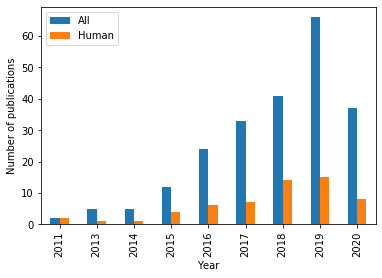

In [49]:
ax = article_df.plot.bar()
ax.set_ylabel('Number of publications')

In [77]:
%%bash
redbiom search metadata "exercise_frequency where qiita_study_id == 10317" > ../doc/agp.ids
redbiom summarize metadata-category --category "exercise_frequency" --dump > ../doc/exercise_frequency.ids

In [79]:
with open('../doc/agp.ids', 'r') as f:
    agp_ids = [line.rstrip() for line in f.readlines()]

In [80]:
exercise = pd.read_csv('../doc/exercise_frequency.ids', sep='\t', index_col=0)

In [110]:
frequencies = ['Never', 'Rarely (a few times/month)', 'Occasionally (1-2 times/week)', 'Regularly (3-5 times/week)', 'Daily']
mapping = {day: i for i, day in enumerate(frequencies)}
key = exercise['exercise_frequency'].map(mapping)
key = key.dropna()
exercise_drops = exercise.loc[key.index]
exercise_drops["exercise_frequency"].value_counts()

Regularly (3-5 times/week)       9270
Occasionally (1-2 times/week)    6217
Daily                            5133
Rarely (a few times/month)       3132
Never                             806
Name: exercise_frequency, dtype: int64

[Text(0, 0, 'Never (n=806)'),
 Text(0, 0, 'Rarely (n=4132)'),
 Text(0, 0, 'Occasionally (n=6217)'),
 Text(0, 0, 'Regularly (n=9270)'),
 Text(0, 0, 'Daily (n=5133)')]

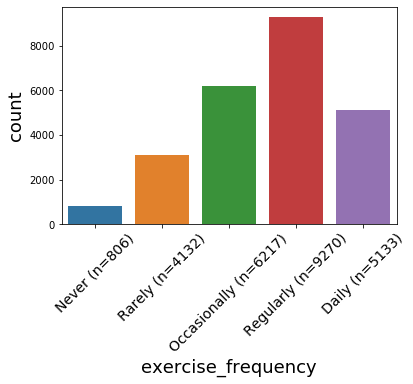

In [114]:
ax = sns.countplot(x='exercise_frequency', data=exercise_drops, order=['Never', 'Rarely (a few times/month)', 'Occasionally (1-2 times/week)', 
                                                                       'Regularly (3-5 times/week)', 'Daily'])
ax.set_xticklabels(["Never (n=806)", "Rarely (n=3132)", "Occasionally (n=6217)", "Regularly (n=9270)", "Daily (n=5133)"], rotation=45)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

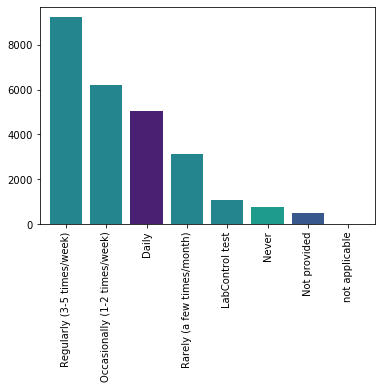

In [90]:
viridis = cm.get_cmap('viridis', 12)
ax = plot.bar(color=[viridis(np.random.random()) for i in range(len(exercise))], width=0.8)